In [357]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.cube.models import SkyModel, SkyModels


In [358]:
#load irfs...
def get_irfs():
    filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
    aeff = EffectiveAreaTable2D.read(filename, hdu='EFFECTIVE AREA')
    edisp = EnergyDispersion2D.read(filename, hdu='ENERGY DISPERSION')
    bkg = Background3D.read(filename, hdu='BACKGROUND')
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)

irfs=get_irfs()

In [359]:
#define the geom
src=SkyCoord(280.4652, -32.8884, unit='deg', frame='galactic')
elow = 0.8
ehigh = 20.0
energy_axis = MapAxis.from_bounds(elow, ehigh, 30, name='energy', unit='TeV', interp='log')
geom3d = WcsGeom.create(binsz=0.5, skydir=src, width=7.0, coordsys='GAL',
                       axes=[energy_axis])
energy_axis_1bin = MapAxis.from_bounds(elow, ehigh, 1, name='energy', unit='TeV', interp='log')
geom2d = geom3d.to_image().to_cube(axes=[energy_axis_1bin])

In [360]:
#The models

ampl = 0.5e-11/(u.cm *u.cm * u.s *u.TeV)
sig = 1.0 * u.deg

spatial_model = SkyGaussian(
    lon_0=src.galactic.l,
    lat_0=src.galactic.b,
    sigma=sig,
)
spectral_model = PowerLaw(
    index=2.0,
    amplitude=ampl,
    reference='1 TeV',
)
sky_model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
)

### First get the exposure and background

In [361]:
livetime = 10 * u.hour
offset_max = 2.3 * u.deg
pointing=src

exposure_map3d = make_map_exposure_true_energy(
        pointing=pointing, livetime=livetime, aeff=irfs['aeff'],
        geom=geom3d
        )
    
background3d = make_map_background_irf(
        pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom3d
        ) 

Transform to 2D, doing all the weird ugly jugglery

In [362]:
background2d =  background3d.sum_over_axes()
b1 = np.reshape(background2d.data,(1,background2d.data.shape[0],background2d.data.shape[0]))
background = WcsNDMap(geom2d, b1)

In [363]:
from gammapy.cube.exposure import _map_spectrum_weight
wt = _map_spectrum_weight(exposure_map3d, spectral_model)
exposure2d = wt.sum_over_axes()
e1 = np.reshape(exposure2d.data,(1,exposure2d.data.shape[0],exposure2d.data.shape[0]))
exposure_map = WcsNDMap(geom2d, e1, unit=exposure_map3d.unit)

In [364]:
background

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (14, 14, 1)
	ndim  : 3
	unit  : '' 
	dtype : float64 

### Do the simulations

In [365]:
%%time
evaluator = MapEvaluator(sky_model, exposure_map)
npred = evaluator.compute_npred()

CPU times: user 6.87 ms, sys: 2.15 ms, total: 9.02 ms
Wall time: 6.75 ms


In [367]:
%%time

n_obs = 25
mu_b = 1.0
sig_b = 0.2

exp_map = []
bkg_map = []
counts_map = []
back_factor = [] #Unknown back normalisation in real life
for i in range(n_obs):    
    
    factor_b = np.random.normal(mu_b, sig_b)
    if factor_b < 0.0:
        print(factor_b)
        continue
        
    
    back_data = background.data * factor_b
    
    rng = np.random.RandomState()
    counts = rng.poisson(npred)
    counts = counts + back_data
    
    cmap = WcsNDMap(geom2d, counts)
    exp_map.append(exposure_map)
    bkg_map.append(background)
    counts_map.append(cmap)
    back_factor.append(factor_b)
    


CPU times: user 4.99 ms, sys: 53 ms, total: 58 ms
Wall time: 56.8 ms


In [369]:
from importlib import reload
import MyLikelihood_3d
reload (MyLikelihood_3d)
from MyLikelihood_3d import *

#### Sanity check - do we get back proper bk with same initial parameters?

In [370]:
mle=MyLikelihood(count_list=counts_map, exposure_list=exp_map, background_list=bkg_map)

#Initial calling parameters
lon0 =  src.galactic.l 
lat0 = src.galactic.b 
sigma1 = sig
amp1 = ampl

maps, comp_bk = mle.calc_bk(lon0, lat0, sigma1, amp1)

In [371]:
comp_bk_ds1 = comp_bk
back_factor_ds1 = back_factor

No handles with labels found to put in legend.


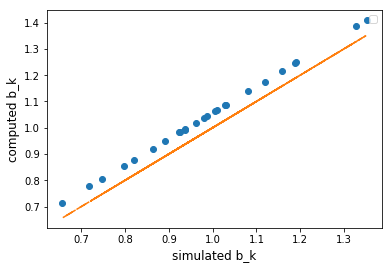

In [374]:
plt.plot(back_factor_ds1, comp_bk_ds1, "o")
#plt.plot(back_factor_ds2, comp_bk_ds2, "o", label="12%")
plt.xlabel("simulated b_k", fontsize = 'large')
plt.ylabel("computed b_k", fontsize = 'large')
plt.plot(back_factor, back_factor, linestyle='dashdot')
plt.legend()

In [375]:
npred.sum()/background.data.sum()

0.058067982863675455

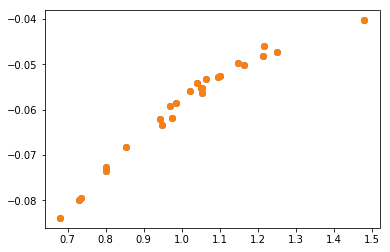

In [263]:
plt.plot(back_factor_ds1,(np.array(back_factor_ds1)-np.array(comp_bk_ds1))/back_factor_ds1, "o")
plt.plot(back_factor_ds1,(np.array(back_factor_ds1)-np.array(comp_bk_ds1))/back_factor_ds1, "o")

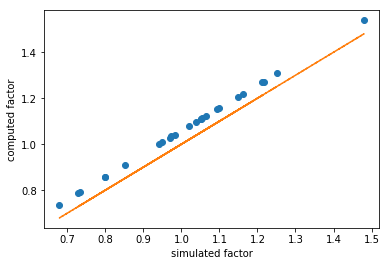

In [264]:
plt.plot(back_factor, comp_bk, "o")
plt.xlabel("simulated factor")
plt.ylabel("computed factor")
plt.plot(back_factor, back_factor, linestyle='dashdot')

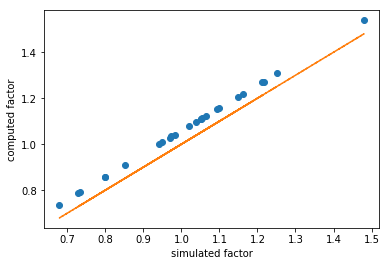

In [265]:
plt.plot(back_factor, comp_bk, "o")
plt.xlabel("simulated factor")
plt.ylabel("computed factor")
plt.plot(back_factor, back_factor, linestyle='dashdot')

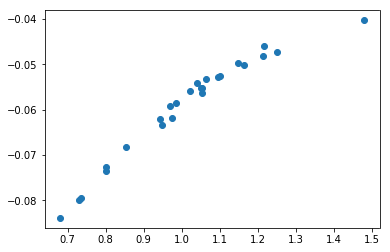

In [266]:
plt.plot(back_factor,np.divide(np.array(back_factor)-np.array(comp_bk),back_factor), "o")

In [267]:
epsilon=5e-2
Nbins = 2e7
print(1/(1+epsilon)-(1-epsilon))

0.0023809523809523725


In [268]:
Sb = np.divide(maps[1].data, background.data)

In [269]:
Sb.sum()

9.155164178846238

In [270]:
Sbmap = WcsNDMap(geom2d, Sb*Sb)

In [271]:
Sbmap.data.sum()

1.681112879694628

(<matplotlib.figure.Figure at 0x18220f0e48>,
 <matplotlib.colorbar.Colorbar at 0x18229d8828>)

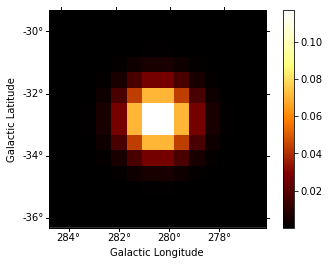

In [272]:
Sbmap.sum_over_axes().plot(add_cbar=True)

In [273]:
20239.67631932381/background.data.sum()

0.33129148078922777

Now lets fits and see

In [376]:
import iminuit

In [377]:
mle = MyLikelihood(count_list=counts_map, exposure_list=exp_map, background_list=bkg_map)
amp2 = ampl.value
sigma2 = 1
#create dict to pass in iminuit
kwarg = dict(
    lon0 =  src.galactic.l.value*1.1,
    lat0 = src.galactic.b.value*1.1,
    amp = amp2 * 1.1,
    sig = sigma2,
    error_lon0 = 0.1,
    error_lat0 = 0.1,
    error_amp = amp2/10.0,
    error_sig= 0.1,
    limit_lon0 = (260, 320),
    limit_lat0 =(-40, -25),
    limit_amp = (0.0, 1e-6),
    limit_sig = (0.1, 7.0)
)

kwarg_fix = dict(
    lon0 =  src.galactic.l.value,
    lat0 = src.galactic.b.value,
    amp = amp2*1.3,
    sig = 1.2,
    error_amp = amp2/10.0,
    limit_amp = (0.0, 1e-6),
    error_sig = 0.1,
    limit_sig = (0.0, 7.0),
    fix_sig = False,
    fix_lon0 = True,
    fix_lat0 = True
)

m = iminuit.Minuit(mle, **kwarg_fix)


/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: InitialParamWarning: errordef is not given. Default to 1.


In [378]:
kwarg_fix

{'amp': 6.5e-12,
 'error_amp': 5e-13,
 'error_sig': 0.1,
 'fix_lat0': True,
 'fix_lon0': True,
 'fix_sig': False,
 'lat0': -32.8884,
 'limit_amp': (0.0, 1e-06),
 'limit_sig': (0.0, 7.0),
 'lon0': 280.4652,
 'sig': 1.2}

In [379]:
%%time
m.migrad()

FCN = -7700996.55129589 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 0.00011374148399218176 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,lon0,280.465,1,0,0,,,FIXED
2,lat0,-32.8884,1,0,0,,,FIXED
3,sig,0.7731,0.010329,0,0,0.0,7.0,
4,amp,2.80817e-12,5.85324e-14,0,0,0.0,1e-06,


CPU times: user 438 ms, sys: 4.42 ms, total: 443 ms
Wall time: 440 ms


({'fval': -7700996.55129589, 'edm': 0.00011374148399218176, 'nfcn': 62, 'up': 1.0, 'is_valid': True, 'has_valid_parameters': True, 'has_accurate_covar': True, 'has_posdef_covar': True, 'has_made_posdef_covar': False, 'hesse_failed': False, 'has_covariance': True, 'is_above_max_edm': False, 'has_reached_call_limit': False},
 [{'number': 0, 'name': 'lon0', 'value': 280.4652, 'error': 1.0, 'is_const': False, 'is_fixed': True, 'has_limits': False, 'has_lower_limit': False, 'has_upper_limit': False, 'lower_limit': 0.0, 'upper_limit': 0.0},
  {'number': 1, 'name': 'lat0', 'value': -32.8884, 'error': 1.0, 'is_const': False, 'is_fixed': True, 'has_limits': False, 'has_lower_limit': False, 'has_upper_limit': False, 'lower_limit': 0.0, 'upper_limit': 0.0},
  {'number': 2, 'name': 'sig', 'value': 0.7731000045543185, 'error': 0.010328970557473782, 'is_const': False, 'is_fixed': False, 'has_limits': True, 'has_lower_limit': True, 'has_upper_limit': True, 'lower_limit': 0.0, 'upper_limit': 7.0},
  {

In [380]:
m.values

{'amp': 2.808172468893311e-12,
 'lat0': -32.8884,
 'lon0': 280.4652,
 'sig': 0.7731000045543185}

In [381]:
m.errors

{'amp': 5.853236487163294e-14,
 'lat0': 1.0,
 'lon0': 1.0,
 'sig': 0.010328970557473782}

In [382]:
print(m1.values['sig'],m1.errors['sig'],m2.values['sig'],m2.errors['sig'])
print(m1.values['amp'],m1.errors['amp'],m2.values['amp'],m2.errors['amp'])

1.0000000000000002 3.5215085284600565 1.0000000000000002 3.5215085284600565
5.499999999991623e-12 7.098535000990071e-07 5.499999999991623e-12 7.098535000990071e-07


In [383]:
m



In [384]:
maps1, comp_bk1 = mle.calc_bk(lon0, lat0, m.values['sig']*u.deg, m.values['amp']*ampl.unit)

In [385]:
comp_bk1

[1.246292717804819,
 1.0674230256750272,
 0.9203215980121371,
 0.8061458268816315,
 0.9931636207289722,
 1.0644262825436837,
 0.9848543137489928,
 1.0453936161621966,
 1.1758851860239483,
 0.877746071305484,
 1.4090064173524857,
 1.037362922201495,
 0.9946398915449277,
 0.8531075578107326,
 1.3864135505489967,
 1.2491563638816072,
 1.1382900684671835,
 1.0878471655120618,
 0.9494170941841863,
 0.982571354937956,
 1.0197185277786793,
 0.7766724017889602,
 1.0876645910454146,
 0.7148807521779362,
 1.2161789592703416]

In [386]:
ampl.unit

Unit("1 / (cm2 s TeV)")

In [387]:
t1 = mle.calc_res(src.galactic.l, src.galactic.b, m.values['sig']*u.deg, m.values['amp']*ampl.unit, )

In [388]:
t2 = mle.calc_res(src.galactic.l, src.galactic.b, m.values['sig']*u.deg, 0.0*ampl.unit, )

In [389]:
t1,t2, t2-t1

(-7700996.55129589, -7696910.574688755, 4085.9766071345657)

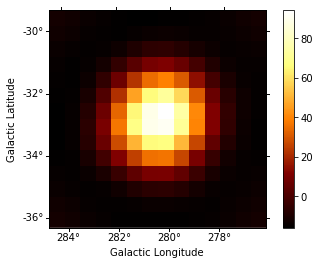

In [390]:
#get residual maps
resmap = WcsNDMap(geom2d)
for i in range(1):
    bk = counts_map[i].data.sum()/background.data.sum()
    res = counts_map[i].data - bk * background.data
    resmap.data = resmap.data + res
resmap.slice_by_idx({"energy": 0}).smooth(width=1).plot(add_cbar=True);

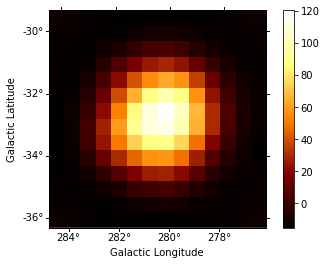

In [391]:
#get residual maps with source
resmap_src = WcsNDMap(geom2d)
for i in range(1):
    bk = back_factor[i]
    res = counts_map[i].data - bk * background.data - maps1[i].data
    resmap_src.data = resmap.data + res
resmap_src.slice_by_idx({"energy": 0}).smooth(width=1).plot(add_cbar=True);

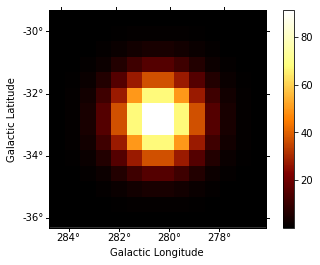

In [351]:
maps1[0].slice_by_idx({"energy": 0}).smooth(width=1).plot(add_cbar=True);

(<matplotlib.figure.Figure at 0x1823c6a518>,
 <matplotlib.colorbar.Colorbar at 0x182456e940>)

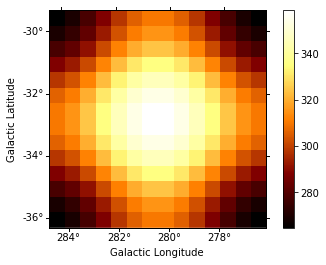

In [339]:
background.slice_by_idx({"energy": 0}).smooth(width=3).plot(add_cbar=True)

(<matplotlib.figure.Figure at 0x1823ff2da0>,
 <matplotlib.colorbar.Colorbar at 0x18242b5fd0>)

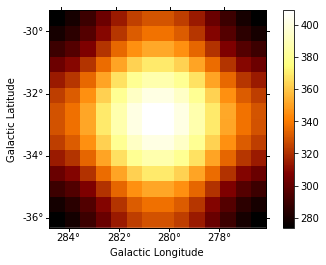

In [338]:
diffuse_map[0].slice_by_idx({"energy": 0}).smooth(width=3).plot(add_cbar=True)

In [334]:
resmap.data - resmap_src.data

array([[[ 10.03776526,  11.31616328,  12.63474265,  13.74122385,
          14.64599096,  15.35799149,  15.74695218,  15.74695218,
          15.35799149,  14.64599096,  13.74122385,  12.63474265,
          11.31616328,  10.03776526],
        [ 11.32177229,  12.92363081,  13.33582109,  15.75659416,
          16.98074254,  15.92063514,  16.41750861,  14.41750861,
          12.92063514,  16.98074254,  15.75659416,  14.33582109,
          12.92363081,  11.32177229],
        [ 12.64630516,  14.34183159,  15.17890249,  15.92933055,
          14.6249695 ,  16.94889205,  12.79826402,  10.79826402,
          13.94889205,  17.6249695 ,  15.92933055,  14.17890249,
          14.34183159,  12.64630516],
        [ 13.75851559,  15.76860608,  15.93547913,  19.3303108 ,
          10.99401047,   9.16487834,  -6.13175013,   5.86824987,
           8.16487834,   6.99401047,  14.3303108 ,  13.93547913,
          14.76860608,  13.75851559],
        [ 14.66833168,  15.99821925,  17.6369346 ,   9.0001421 ,
   